# Revenus des data-scientist à travers le monde

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(color_codes=True)

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.tools as tls

In [2]:
multiple_choice=pd.read_csv('./data/multipleChoiceResponses.csv',encoding='ISO-8859-1')
data=multiple_choice[['GenderSelect','Country','Age','EmploymentStatus','CurrentJobTitleSelect','CurrentEmployerType','EmployerIndustry','EmployerSize','UniversityImportance','CompensationAmount','CompensationCurrency','SalaryChange']]

/home/nicolas-dufour/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning:

Columns (31,83,86,87,98,99,109,116,123,124,127,129,130,164) have mixed types. Specify dtype option on import or set low_memory=False.



In [3]:
#On garde que les valeurs coherentes
data['CompensationAmount'] = data['CompensationAmount'].fillna(0)
data['CompensationAmount'] = data.CompensationAmount.apply(lambda x: 0 if (pd.isnull(x) or (x=='-') or (x==0))
                                                       else float(x.replace(',','')))
data = data[(data['CompensationAmount']>10000) & (data['CompensationAmount']<2000000)]
# on vagarder que les valeurs ou le nombre de réponses est dignificatig
s_temp = data['Country'].value_counts()
s_temp = s_temp[s_temp>75]
countries=list(s_temp.index)
print(len(countries))
countries.remove('Other')
print(countries)
data=data[data.Country.isin(countries)]
# On remplace les valeurs manquante pour ne pas supprimer lesvaleurs manquantes
data['CompensationCurrency'] =data.groupby('Country')['CompensationCurrency'].apply(lambda x: x.fillna(x.value_counts().idxmax()))

14
['United States', 'India', 'United Kingdom', 'Germany', 'France', 'Canada', 'Brazil', 'Russia', 'Australia', 'Spain', 'Italy', 'Netherlands', "People 's Republic of China"]


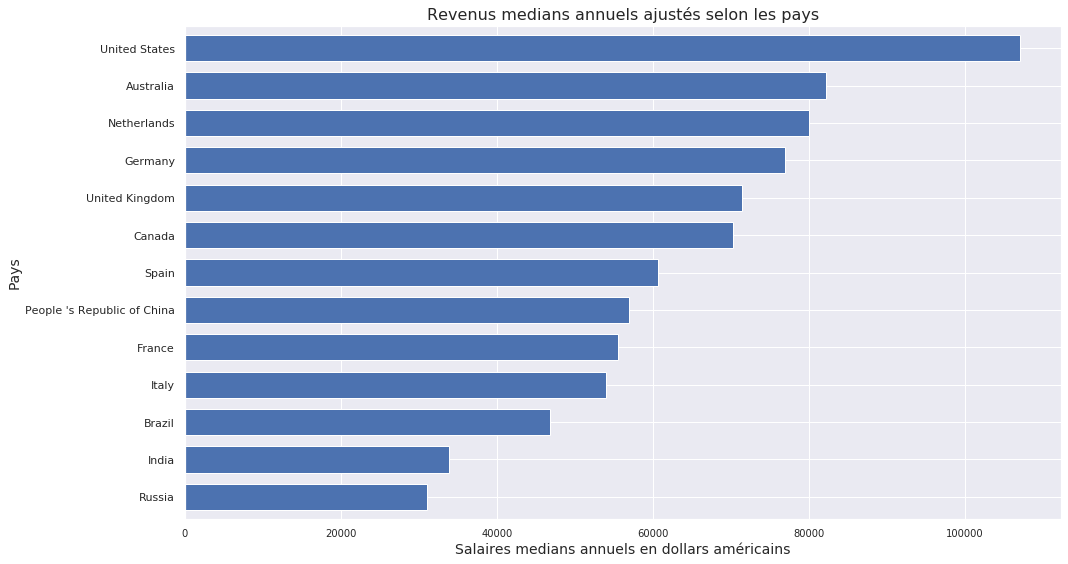

In [4]:
#The PPP rates
rates_ppp={'Countries':['United States','India','United Kingdom','Germany','France','Brazil','Canada','Spain','Australia','Russia','Italy',"People 's Republic of China",'Netherlands'],
           'Currency':['USD','INR','GBP','EUR','EUR','BRL','CAD','EUR','AUD','RUB','EUR','CNY','EUR'],
           'PPP':[1.00,17.7,0.7,0.78,0.81,2.05,1.21,0.66,1.46,25.13,0.74,3.51,0.8]}

rates_ppp = pd.DataFrame(data=rates_ppp)
#taux d'echange
rates_mer=pd.read_csv('./data/conversionRates.csv', encoding="ISO-8859-1")
rates_mer.drop('Unnamed: 0',inplace=True,axis=1)
rates=rates_ppp.merge(rates_mer,left_on='Currency',right_on='originCountry',how='left')
rates['PPP/MER']=rates['PPP']*rates['exchangeRate']

#keep the PPP/MER rates plus the 'Countries' column that will be used for the merge
rates=rates[['Countries','PPP','PPP/MER']]
data=data.merge(rates_mer,left_on='CompensationCurrency',right_on='originCountry',how='left')
data=data.merge(rates,left_on='Country',right_on='Countries',how='left')

data['AdjustedSalary']=data['CompensationAmount']*data['exchangeRate']/data['PPP/MER']
data=data.drop(3036)
d_salary = {}
for country in data['Country'].value_counts().index :
    d_salary[country]=data[data['Country']==country]['AdjustedSalary'].median()
    
median_wages = pd.DataFrame.from_dict(data=d_salary, orient='index').round(2)
median_wages.sort_values(by=list(median_wages),axis=0, ascending=True, inplace=True)
ax = median_wages.plot(kind='barh',figsize=(15,8),width=0.7,align='center')
ax.legend_.remove()
ax.set_title("Revenus medians annuels ajustés selon les pays",fontsize=16)
ax.set_xlabel("Salaires medians annuels en dollars américains", fontsize=14)
ax.set_ylabel("Pays", fontsize=14)
for tick in ax.get_xticklabels():
    tick.set_rotation(0)
    tick.set_fontsize(10)
plt.tight_layout()

plt.show()

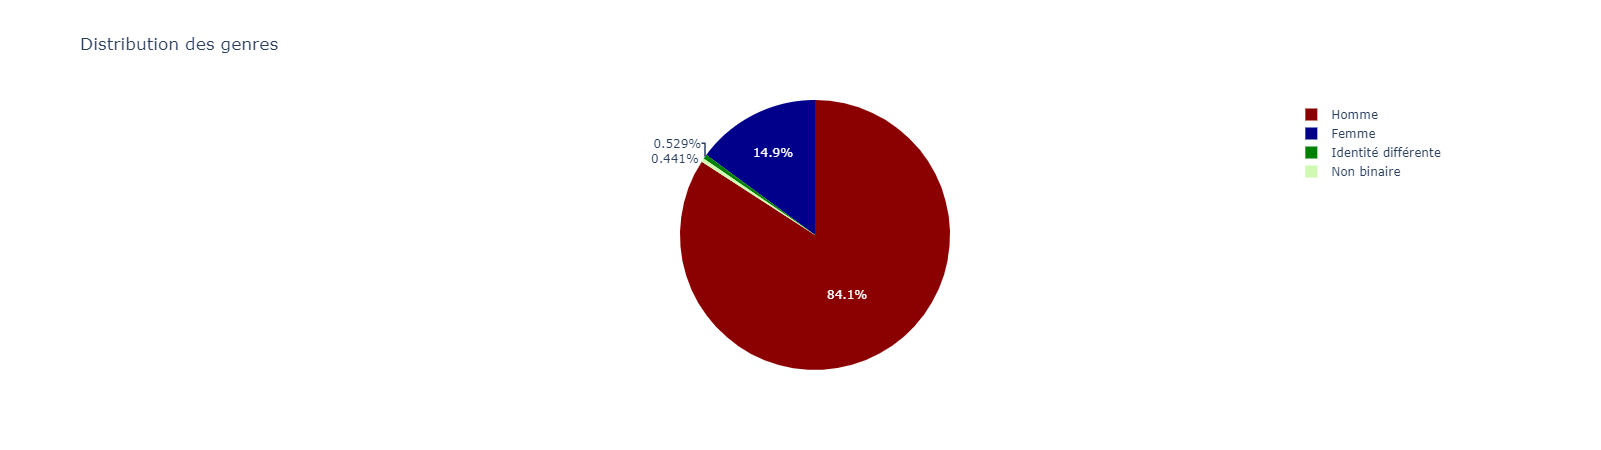

In [5]:
colors = ['darkred', 'darkblue', 'green', '#D0F9B1', 'khaki', 'grey']
data['GenderSelect'] = np.where(data['GenderSelect'] == "Non-binary, genderqueer, or gender non-conforming",'Non-binary',
                             data['GenderSelect'])

gender = data['GenderSelect'].value_counts()
label = ['Homme','Femme','Identité différente','Non binaire'] #gender.index
size = gender.values

trace = go.Pie(labels=label, 
               values=size, 
               marker=dict(colors=colors))

donnee = [trace]
layout = go.Layout(title='Distribution des genres')

fig = go.Figure(data=donnee, layout=layout)
py.iplot(fig)

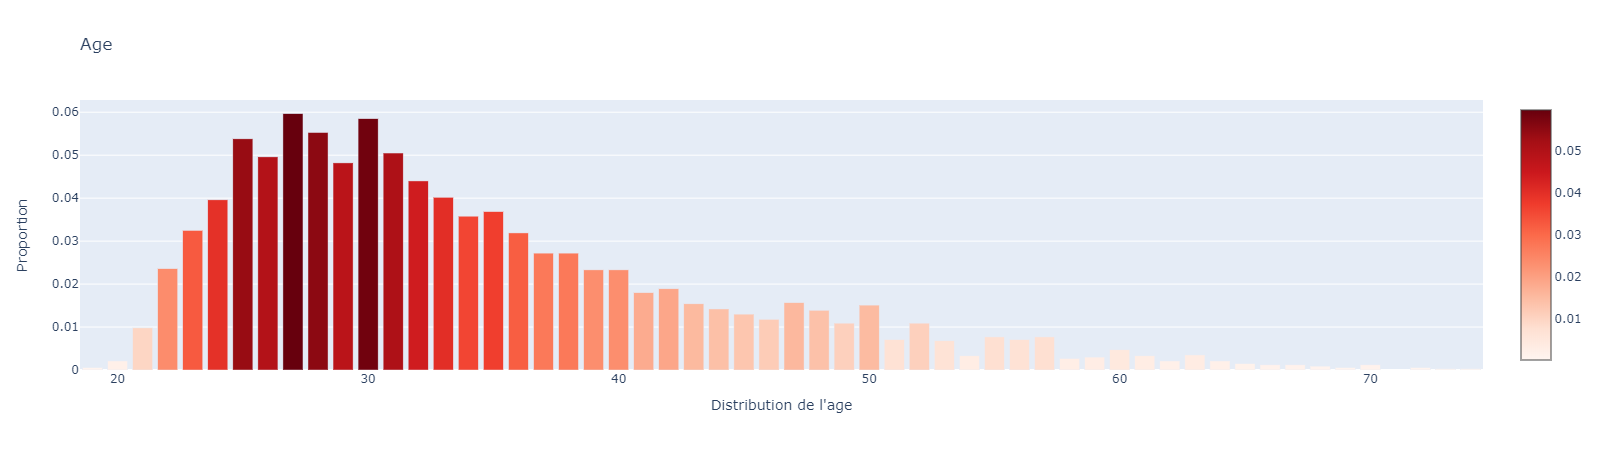

In [6]:
data = data[(data['Age'] < 75) & (data['Age'] > 18)]
age = round(data['Age'].value_counts(normalize=True), 4)
trace = go.Bar(
    x=age.index,
    y=age.values,
    marker=dict(
        color = age.values,
        colorscale='Reds',
        showscale=True)
)

donnee = [trace]
layout = go.Layout(title='Age', 
                   yaxis = dict(title = 'Proportion')
                  )

fig = go.Figure(data=donnee, layout=layout)
fig['layout']['xaxis'].update(dict(title = 'Distribution de l\'age', 
                                   tickfont = dict(size = 12)))
py.iplot(fig)

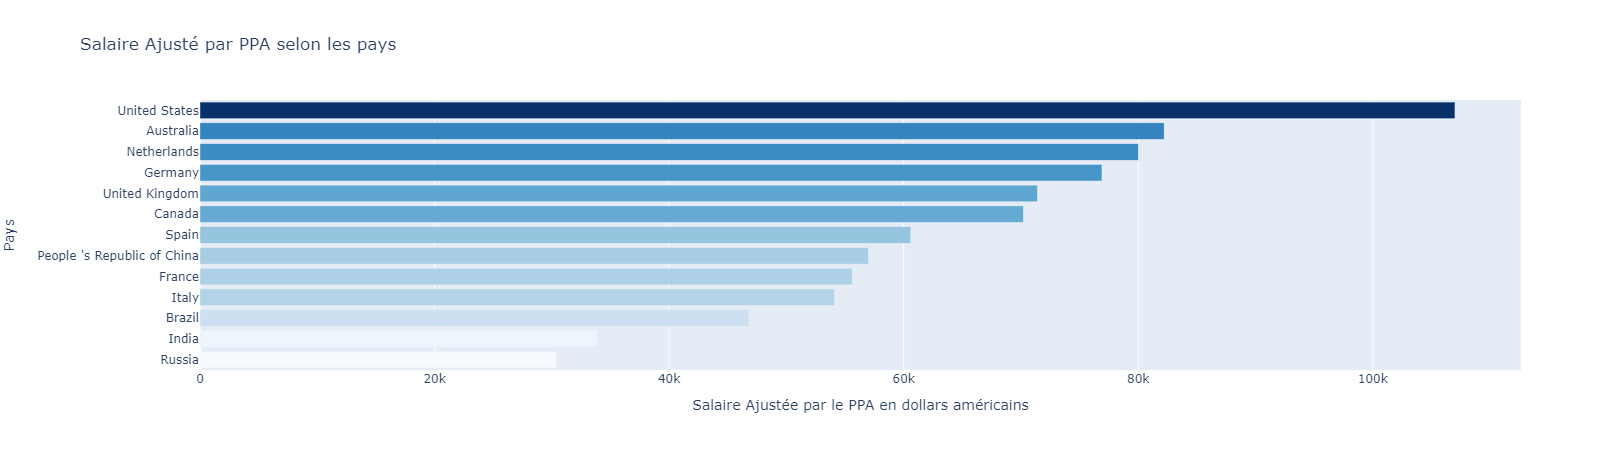

In [7]:
sal_coun=data.groupby('Country')['AdjustedSalary'].median().round(-2).sort_values(ascending=True).\
                                    to_frame()

trace = go.Bar(
    y=sal_coun.index,
    x=sal_coun.AdjustedSalary,
    orientation='h',
    marker=dict(
        color=sal_coun.AdjustedSalary,
        colorscale = 'Blues')
)

donnee = [trace]
layout = go.Layout(
    title='Salaire Ajusté par PPA selon les pays', 
    yaxis = dict(title = 'Pays'),
    xaxis=dict(title='Salaire Ajustée par le PPA en dollars américains')
)

fig = go.Figure(data=donnee, layout=layout)
py.iplot(fig)

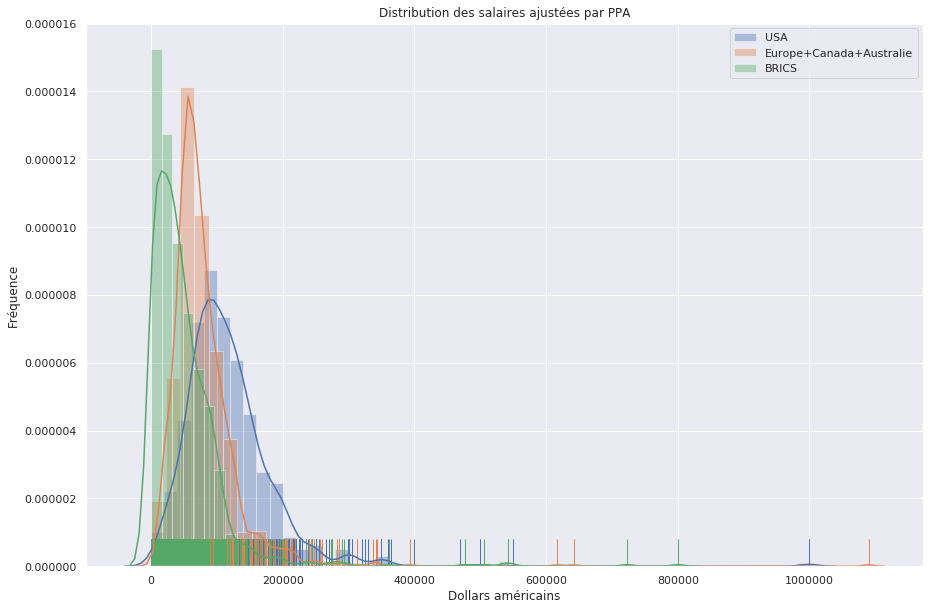

In [14]:
fig=plt.figure(figsize=(15,10))
data['Group']=np.select([data['Country']=='United States',data.Country.isin(['Spain','France','Germany','Canada','United Kingdom','Netherlands','Italy','Australia','Canada']),data.Country.isin(['India','Russia','Brazil',"People 's Republic of China"])],['USA','Europe+Canada+Australie','BRICS'])
grouped=data.groupby('Group')
hist=[data[data['Group']=='USA']['AdjustedSalary'],data[data['Group']=='Europe+Canada+Australie']['AdjustedSalary'],data[data['Group']=='BRICS']['AdjustedSalary']]
groups=['USA','Europe+Canada+Australie','BRICS']
for i,j in zip(hist,groups):
    sns.distplot(i,label=j,rug=True)
plt.legend()
plt.xlabel('Dollars américains')
plt.ylabel('Fréquence')
plt.title('Distribution des salaires ajustées par PPA')
plt.show()

Group
BRICS                       794
Europe+Canada+Australie    1091
USA                        1499
Name: AdjustedSalary, dtype: int64
Mood test 1: (200.9042840732751, 1.3258641987359975e-45, 57851.23966942149, array([[241, 693],
       [553, 398]]))
Mood test 2: (324.9181535457586, 1.229266368332488e-72, 89041.09589041097, array([[316, 973],
       [775, 526]]))
Mood test 3: (532.1639400789626, 9.55374675587817e-118, 85000.0, array([[1000,  127],
       [ 499,  667]]))


Text(0.5, 1.0, 'Boxplot du salaire ajusté par catégories')

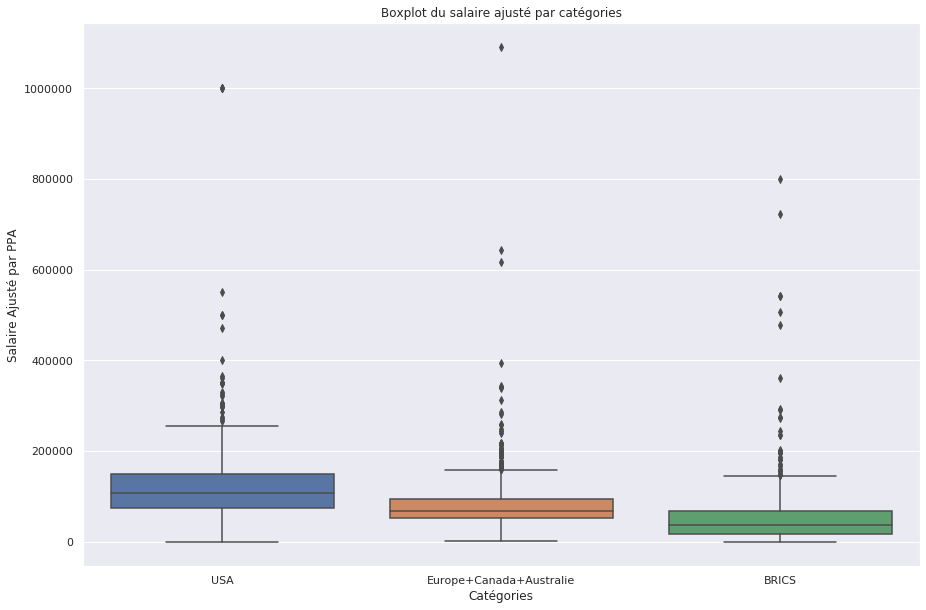

In [9]:
from scipy.stats import median_test
print(data.groupby(['Group']).count()['AdjustedSalary'])
rev_brics=data[data['Group']=='BRICS']['AdjustedSalary']
rev_EU=data[data['Group']=='Europe+Canada+Australie']['AdjustedSalary']
rev_USA=data[data['Group']=='USA']['AdjustedSalary']

print('Mood test 1: '+str(median_test(rev_brics,rev_EU)))
print('Mood test 2: '+str(median_test(rev_EU,rev_USA)))
print('Mood test 3: '+str(median_test(rev_USA,rev_brics)))



fig=plt.figure(figsize=(15,10))
sns.boxplot(data=data,y='AdjustedSalary',x='Group')
plt.ylabel('Salaire Ajusté par PPA')
plt.xlabel('Catégories')
plt.title('Boxplot du salaire ajusté par catégories')

Mood test 1: (5.791139719803105, 0.016107143394814786, 37021.34337727558, array([[ 36, 359],
       [ 59, 336]]))
Mood test 2: (15.125160195478273, 0.00010061338439653846, 68181.81818181818, array([[ 45, 491],
       [ 89, 454]]))
Mood test 3: (19.333159322821295, 1.0978319530779193e-05, 107000.0, array([[103, 634],
       [171, 573]]))
GenderSelect  Group                  
Female        BRICS                       28248.587571
              Europe+Canada+Australie     58974.358974
              USA                         89250.000000
Male          BRICS                       39548.022599
              Europe+Canada+Australie     70247.933884
              USA                        110000.000000
Name: AdjustedSalary, dtype: float64


<Figure size 4320x1440 with 0 Axes>

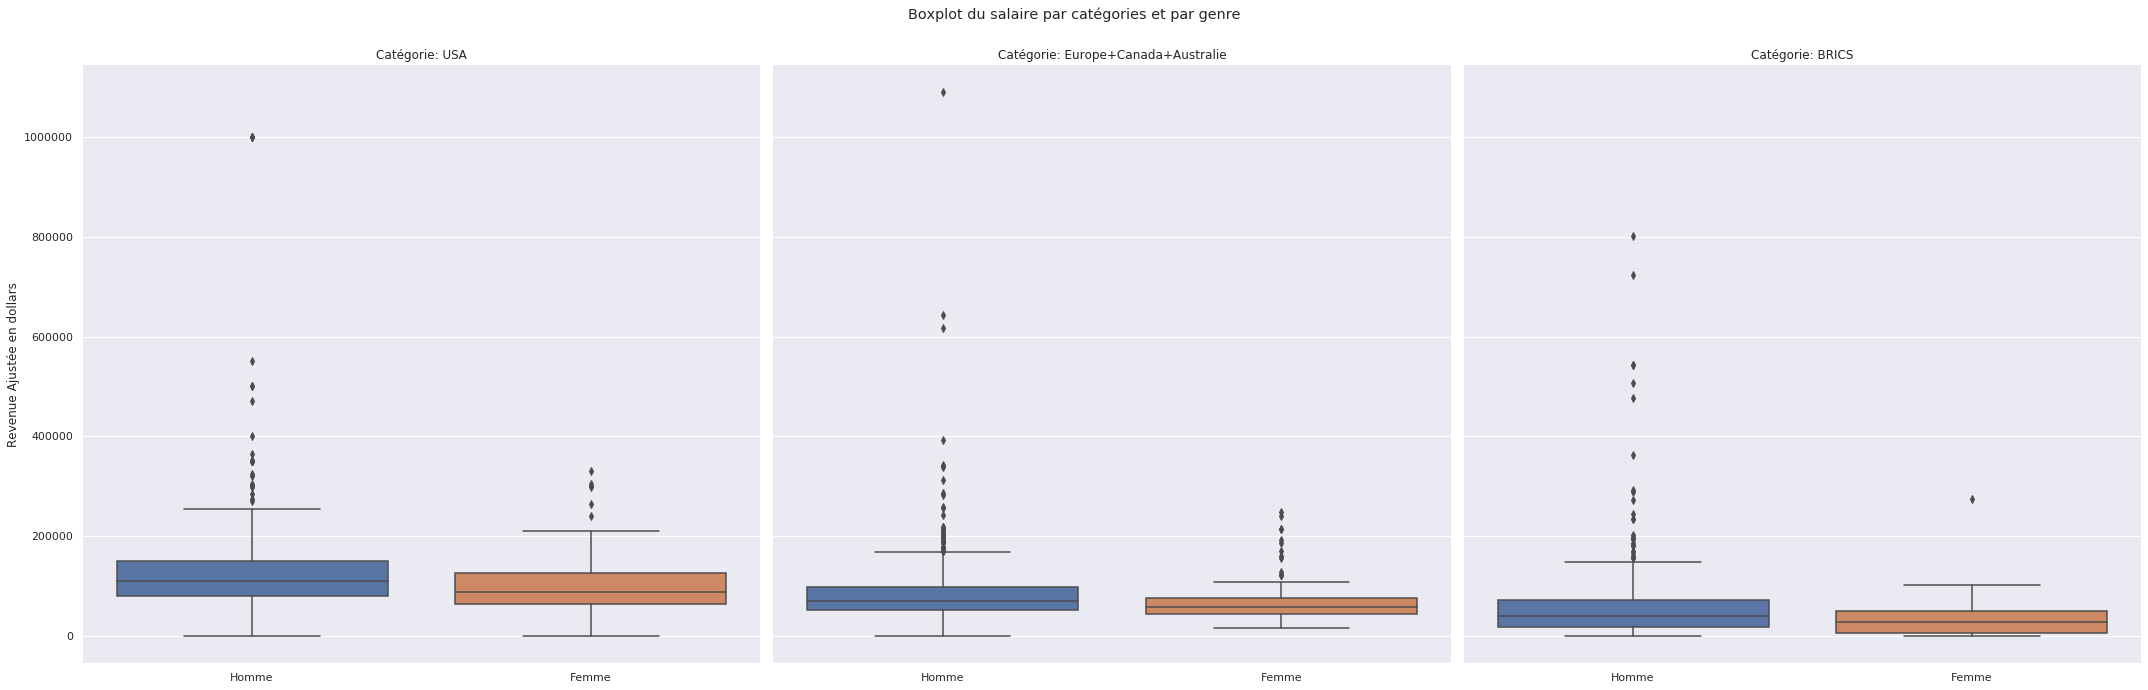

In [21]:
fig=plt.figure(figsize=(60,20))
# plt.ylabel('Salaire Ajusté par PPA')
# plt.xlabel('Catégories')
# plt.title('Boxplot du salaire ajusté par catégories')
sex_by_group=data[data['GenderSelect'].isin(['Male','Female'])]

brics_f=sex_by_group[(sex_by_group['Group']=='BRICS') & (sex_by_group['GenderSelect']=='Female')]['AdjustedSalary']
brics_h=sex_by_group[(sex_by_group['Group']=='BRICS') & (sex_by_group['GenderSelect']=='Male')]['AdjustedSalary']

print('Mood test 1: '+str(median_test(brics_f,brics_h)))

eu_f=sex_by_group[(sex_by_group['Group']=='Europe+Canada+Australie') & (sex_by_group['GenderSelect']=='Female')]['AdjustedSalary']
eu_h=sex_by_group[(sex_by_group['Group']=='Europe+Canada+Australie') & (sex_by_group['GenderSelect']=='Male')]['AdjustedSalary']

print('Mood test 2: '+str(median_test(eu_f,eu_h)))

usa_f=sex_by_group[(sex_by_group['Group']=='USA') & (sex_by_group['GenderSelect']=='Female')]['AdjustedSalary']
usa_h=sex_by_group[(sex_by_group['Group']=='USA') & (sex_by_group['GenderSelect']=='Male')]['AdjustedSalary']

print('Mood test 3: '+str(median_test(usa_f,usa_h)))

print(sex_by_group.groupby(['GenderSelect','Group']).median()['AdjustedSalary'])

g=sns.catplot(data=sex_by_group,y='AdjustedSalary',x='GenderSelect',col='Group',kind="box",height =10)
(g.set_axis_labels("", "Revenue Ajustée en dollars")
    .set_xticklabels(["Homme", "Femme", "Identitée différente",'Non binaire'])
    .set_titles("Catégorie: {col_name}")
    .despine(left=True))
plt.subplots_adjust(top=0.9)

g.fig.suptitle('Boxplot du salaire par catégories et par genre')
plt.show()

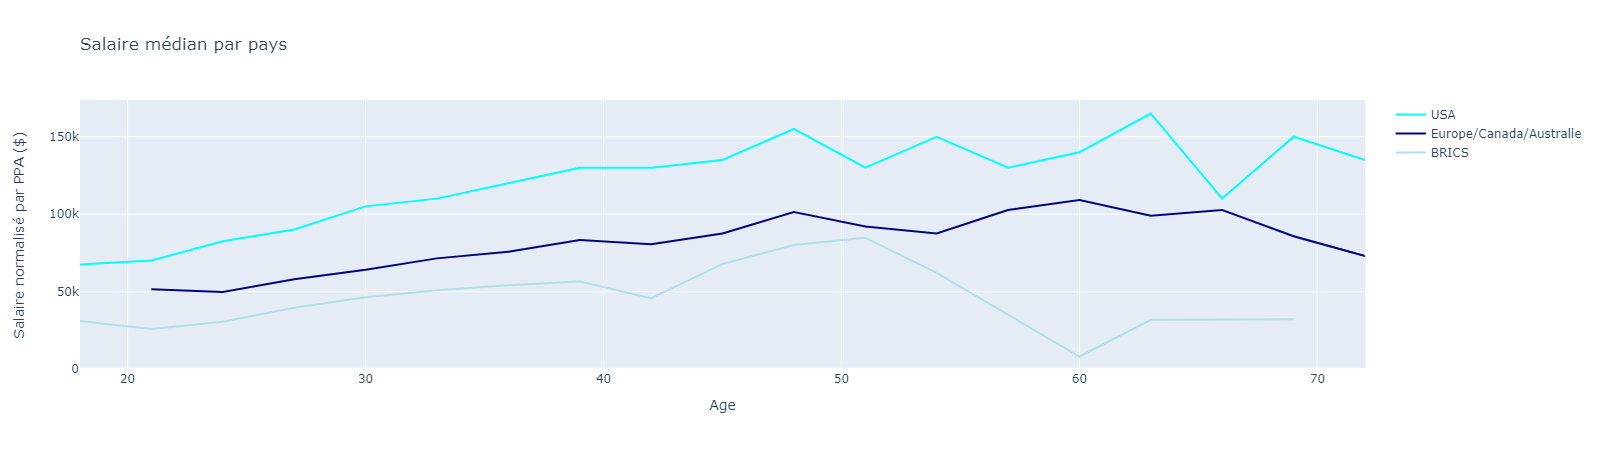

In [22]:
age_data=data
age_data['Bin']=age_data['Age'].apply(lambda x: 3*np.floor(x/3))
usa = age_data[age_data['Group']=='USA'].groupby('Bin')['AdjustedSalary'].median().to_frame()
europe = age_data[age_data['Group']=='Europe+Canada+Australie'].groupby('Bin')['AdjustedSalary'].median().to_frame()
brics = age_data[age_data['Group']=='BRICS'].groupby('Bin')['AdjustedSalary'].median().to_frame()


trace0 = go.Scatter(
    x = usa.index,
    y = usa['AdjustedSalary'].round(-2),
    name = 'USA',
    mode='lines',
    marker=dict(
        size=9,
        color = ('aqua')))

trace1 = go.Scatter(
    x = europe.index,
    y = europe['AdjustedSalary'].round(-2),
    name = 'Europe/Canada/Australie',
    mode='lines',
    marker=dict(
        size=9,
        color = ('navy')))

trace2 = go.Scatter(
    x = brics.index,
    y = brics['AdjustedSalary'].round(-2),
    name = 'BRICS',
    mode='lines',
    marker=dict(
        size=9,
        color = ('PowderBlue')))

donnee = [trace0, trace1,trace2]
layout = dict(title = 'Salaire médian par pays',
              xaxis = dict(title = 'Age'),
              yaxis = dict(title = 'Salaire normalisé par PPA ($)')
             )

fig = dict(data=donnee, layout=layout)
fig['layout']['xaxis'].update(dict(title = 'Age', tickfont = dict(size = 12)))
py.iplot(fig)

In [12]:
inflations={'Countries':['United States','India','United Kingdom','Germany','France','Brazil','Canada','Spain','Australia','Russia','Italy',"People 's Republic of China",'Netherlands'],
           'CPI_2013':[106.83,131.98,110.15,105.68,105.01,119.37,105.45,107.21,107.70,121.64,107.20,111.16,107.48],
           'CPI_2017':[113.10,162.01,116.51,109.6,107.1,156.73,112.39,109.13,113.48,168.50,108.61,119.75,111.55],
           'medians_2013':[15480,615,12399,14098,12445,2247,15181,7284,15026,4129,6874,1786,14450]}

rates_inflations = pd.DataFrame(inflations)
rates_inflations['adjusted_medians']=(rates_inflations['medians_2013']*rates_inflations['CPI_2017']/rates_inflations['CPI_2013']).round(2)
tmp=median_wages.reset_index()
tmp = tmp.rename(columns={'index': 'Country', 0: 'median_income'})

rates_inflations=rates_inflations.merge(tmp,left_on='Countries',right_on='Country',how='left')
rates_inflations['ratio_incomes']=(rates_inflations['median_income']/rates_inflations['adjusted_medians']).round(2)

tmp2=rates_inflations[['Country','ratio_incomes']]
tmp2.sort_values(by='ratio_incomes',axis=0, ascending=True, inplace=True)

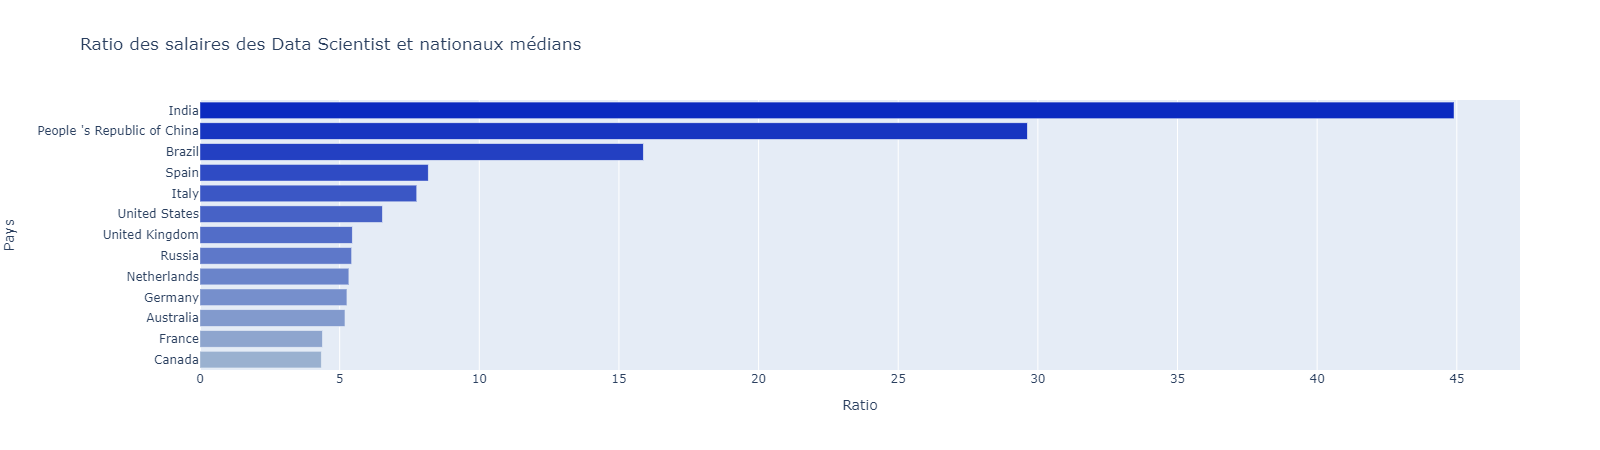

In [23]:

trace = go.Bar(
    y=tmp2.Country,
    x=tmp2.ratio_incomes,
    orientation='h',
    marker=dict(
        color=['#9AB1D0', '#8EA5CE', '#829ACD', '#768FCC', '#6A84CA','#5E78C9','#526DC8','#4762C6','#3B57C5','#2F4BC4','#2340C2','#1735C1','#0B2AC0','#001FBF'],
    )
)

donnee = [trace]
layout = go.Layout(
    title='Ratio des salaires des Data Scientist et nationaux médians', 
    yaxis = dict(title = 'Pays'),
    xaxis=dict(title='Ratio')
)

fig = go.Figure(data=donnee, layout=layout)
py.iplot(fig)